In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tenseal as ts
import gc

SEED = 42
BATCH_SIZE = 128
NUM_CLIENTS = 6
PUBLIC_DATA_RATIO = 0.05 
VAL_SIZE = 0.1
ROUNDS = 5
LOCAL_EPOCHS = 3 
TEMPERATURE = 3.0       

# DP_CLIP_NORM: Limits the maximum influence of any single client's update.
# DP_NOISE_STD: Standard deviation of the Gaussian noise added.
DP_CLIP_NORM = 5.0      
DP_NOISE_STD = 0.5      

torch.manual_seed(SEED)
np.random.seed(SEED)

DATASET_DIR = r"C:\Users\SREENITHI\PrivacyPreservingFederatedLearning_IDS _HE\data"
csv_files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))

mini_batches = []
SAMPLES_PER_FILE = 20000 

print(f"Loading {len(csv_files)} files...")
for f in csv_files:
    try:
        df_chunk = pd.read_csv(f)
        df_chunk.columns = df_chunk.columns.str.strip()
        df_chunk = df_chunk.replace([np.inf, -np.inf], np.nan).dropna()
        if len(df_chunk) > SAMPLES_PER_FILE:
            df_chunk = df_chunk.sample(n=SAMPLES_PER_FILE, random_state=SEED)
        mini_batches.append(df_chunk)
        del df_chunk 
        gc.collect()
    except Exception as e:
        print(f"Skipping {f}: {e}")

if not mini_batches:
    print("No data loaded. Please check the DATASET_DIR path.")
    data = pd.DataFrame(np.random.rand(1000, 78), columns=[f"feat_{i}" for i in range(78)])
    data["Label"] = np.random.randint(0, 2, 1000)
else:
    data = pd.concat(mini_batches, ignore_index=True)

y_raw = data["Label"].values
X_df = data.drop(columns=["Label"]).apply(pd.to_numeric, errors="coerce").fillna(0)
X_raw = np.clip(X_df.to_numpy(), -1e6, 1e6)

le = LabelEncoder()
y_all = le.fit_transform(y_raw)
OUTPUT_DIM = len(le.classes_)
INPUT_DIM = X_raw.shape[1]

X_train_full, X_test_global, y_train_full, y_test_global = train_test_split(
    X_raw, y_all, test_size=0.15, stratify=y_all, random_state=SEED
)

scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_global = scaler.transform(X_test_global) 

X_train_private, X_public, y_train_private, y_public = train_test_split(
    X_train_full, y_train_full, test_size=PUBLIC_DATA_RATIO, stratify=y_train_full, random_state=SEED
)
X_public_tensor = torch.tensor(X_public, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_global, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_global, dtype=torch.long)


def prepare_clients(X, y, num_clients=5, alpha=0.5):
    idx_by_label = {lbl: np.where(y == lbl)[0] for lbl in np.unique(y)}
    client_indices = {i: [] for i in range(num_clients)}
    for lbl, idxs in idx_by_label.items():
        np.random.shuffle(idxs)
        proportions = (np.random.dirichlet([alpha] * num_clients) * len(idxs)).astype(int)
        while proportions.sum() < len(idxs): proportions[np.argmax(proportions)] += 1
        start = 0
        for cid, cnt in enumerate(proportions):
            client_indices[cid].extend(idxs[start:start + cnt])
            start += cnt
    clients_data = []
    print("\n Client Data Allocation")
    for cid in range(num_clients):
        idxs = client_indices[cid]
        tr_idx, val_idx = train_test_split(idxs, test_size=VAL_SIZE, random_state=SEED)
        clients_data.append({
            'train': (torch.tensor(X[tr_idx], dtype=torch.float32), torch.tensor(y[tr_idx], dtype=torch.long)),
            'val': (torch.tensor(X[val_idx], dtype=torch.float32), torch.tensor(y[val_idx], dtype=torch.long)),
            'n_samples': len(tr_idx)
        })
        print(f"Client {cid}: {len(tr_idx)} Train samples, {len(val_idx)} Val samples")
    return clients_data

clients = prepare_clients(X_train_private, y_train_private, num_clients=NUM_CLIENTS)
TOTAL_TRAIN_SAMPLES = sum(c['n_samples'] for c in clients)

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.generate_galois_keys()
context.global_scale = 2**40

class Client0_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 512), nn.ReLU(), nn.Linear(512, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client1_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 256), nn.ReLU(), nn.Linear(256, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client2_ResMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1, self.fc2 = nn.Linear(INPUT_DIM, 256), nn.Linear(256, OUTPUT_DIM)
    def forward(self, x): return self.fc2(F.relu(self.fc1(x)))

class Client3_BiGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, OUTPUT_DIM)
    def forward(self, x):
        _, h = self.gru(x.unsqueeze(-1))
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))

class Client4_TabAttention(nn.Module):
    def __init__(self, input_dim, output_dim, n_heads=4, embed_dim=32):
        super().__init__()
        self.feature_embed = nn.Linear(1, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim * embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.feature_embed(x)
        attn_out, _ = self.attention(x, x, x)
        x = self.ln(x + attn_out)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Client5_CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(1, 32, 3, padding=1)
        self.fc = nn.Linear(32, OUTPUT_DIM)
    def forward(self, x):
        x = F.adaptive_avg_pool1d(F.relu(self.conv(x.unsqueeze(1))), 1)
        return self.fc(x.squeeze(-1))

models = {
    0: Client0_MLP(), 
    1: Client1_MLP(), 
    2: Client2_ResMLP(), 
    3: Client3_BiGRU(), 
    4: Client4_TabAttention(INPUT_DIM, OUTPUT_DIM),
    5: Client5_CNN1D()
}
optimizers = {cid: optim.Adam(models[cid].parameters(), lr=1e-3) for cid in range(NUM_CLIENTS)}


history_val = {cid: [] for cid in range(NUM_CLIENTS)}
history_train = {cid: [] for cid in range(NUM_CLIENTS)}
client_accuracies = {cid: 0.0 for cid in range(NUM_CLIENTS)}

def get_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
    return accuracy_score(y_true, preds), f1_score(y_true, preds, average="weighted")

def local_train_and_encrypt(cid, aggregation_weight):
    model, opt = models[cid], optimizers[cid]
    Xc, yc = clients[cid]['train']
    
    class_counts = torch.bincount(yc, minlength=OUTPUT_DIM).float()
    total_samples = len(yc)
    class_weights = total_samples / (len(class_counts) * (class_counts + 10))
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights = torch.clamp(class_weights, min=0.1, max=20.0)
    
    model.train()
    for epoch in range(LOCAL_EPOCHS):
        for i in range(0, len(Xc), BATCH_SIZE):
            opt.zero_grad()
            batch_X = Xc[i:i+BATCH_SIZE]
            batch_y = yc[i:i+BATCH_SIZE]
            
            outputs = model(batch_X)
            loss = F.cross_entropy(outputs, batch_y, weight=class_weights)
            loss.backward()
            opt.step()
            
    model.eval()
    with torch.no_grad():
        avg_logits = model(X_public_tensor).mean(dim=0).cpu().numpy()
        
    param_norm = np.linalg.norm(avg_logits)
    if param_norm > DP_CLIP_NORM:
        avg_logits = avg_logits * (DP_CLIP_NORM / param_norm)
        
    noise = np.random.normal(0, DP_NOISE_STD, avg_logits.shape)
    avg_logits_dp = avg_logits + noise
    
    return ts.ckks_vector(context, avg_logits_dp * aggregation_weight)

def server_aggregate(encrypted_list):
    agg = encrypted_list[0]
    for i in range(1, len(encrypted_list)): agg += encrypted_list[i]
    return agg

def client_decryption_and_distill(cid, encrypted_global_vec):
    global_logits_plaintext = encrypted_global_vec.decrypt() 
    target_logits = torch.tensor(global_logits_plaintext, dtype=torch.float32)
    
    model, opt = models[cid], optimizers[cid]
    model.train()
    opt.zero_grad()
    
    student_logits = model(X_public_tensor).mean(dim=0)
    T = TEMPERATURE
    
    loss = nn.KLDivLoss(reduction="batchmean")(
        F.log_softmax(student_logits.unsqueeze(0) / T, dim=1),
        F.softmax(target_logits.unsqueeze(0) / T, dim=1)
    ) * (T * T)
    
    loss.backward()
    opt.step()

print("\n Federated Learning Experiment")
print(f"Clients: {NUM_CLIENTS} | Rounds: {ROUNDS} | Local Epochs: {LOCAL_EPOCHS}")
print(f"Aggregation: weighted; Distillation temperature: {TEMPERATURE}")
print(f"Privacy: CKKS homomorphic encryption; "
      f"Local DP (clipping={DP_CLIP_NORM}, noise_std={DP_NOISE_STD})")

for r in range(ROUNDS):
    if r == 0:
        raw_weights = [clients[cid]['n_samples'] for cid in range(NUM_CLIENTS)]
    else:
        raw_weights = [client_accuracies[cid] + 1e-4 for cid in range(NUM_CLIENTS)]
    
    total_w = sum(raw_weights)
    norm_weights = [w / total_w for w in raw_weights]
    
    print(f"\nRound {r+1} Aggregation Weights: {[f'{w:.3f}' for w in norm_weights]}")

    ciphertexts = [local_train_and_encrypt(cid, norm_weights[cid]) for cid in range(NUM_CLIENTS)]
    encrypted_global = server_aggregate(ciphertexts)
    
    for cid in range(NUM_CLIENTS):
        client_decryption_and_distill(cid, encrypted_global)

    print(f"Round {r+1} Statistics")
    for cid in range(NUM_CLIENTS):
        t_acc, t_f1 = get_metrics(models[cid], clients[cid]['train'][0], clients[cid]['train'][1])
        v_acc, v_f1 = get_metrics(models[cid], clients[cid]['val'][0], clients[cid]['val'][1])
        history_train[cid].append(t_acc)
        history_val[cid].append(v_acc)
        
        client_accuracies[cid] = v_acc
        print(f"Client {cid}: [Train] Acc {t_acc:.4f} | [Val] Acc {v_acc:.4f}")

def ensemble_predict(models, X):
    logits_sum = None
    with torch.no_grad():
        for cid, model in models.items():
            model.eval()
            logits = model(X)
            if logits_sum is None:
                logits_sum = logits
            else:
                logits_sum += logits
        avg_logits = logits_sum / len(models)
        y_pred = torch.argmax(avg_logits, dim=1)
    return y_pred.cpu().numpy()

y_pred_ens = ensemble_predict(models, X_test_tensor)

print(f"Final Global Ensemble Accuracy: {accuracy_score(y_test_global, y_pred_ens):.4f}")
print("\n Client-wise Class Distribution")
for cid in range(NUM_CLIENTS):
    y_client = clients[cid]['train'][1].cpu().numpy()
    unique, counts = np.unique(y_client, return_counts=True)
    dist = dict(zip(le.inverse_transform(unique), counts))
    print(f"Client {cid}: {dist}")

print("\n Final Client-wise Performance ")
for cid in range(NUM_CLIENTS):
    acc, f1 = get_metrics(models[cid], X_test_tensor, y_test_tensor)
    print(f"Client {cid} ({models[cid].__class__.__name__}): Test Acc = {acc:.4f}, Test F1 = {f1:.4f}")

ens_acc = accuracy_score(y_test_global, y_pred_ens)
ens_f1 = f1_score(y_test_global, y_pred_ens, average="weighted")

print("\n Global Ensemble Performance")
print(f"Ensemble Accuracy: {ens_acc:.4f}")
print(f"Ensemble F1-score: {ens_f1:.4f}")


Loading 8 files...

 Client Data Allocation
Client 0: 9376 Train samples, 1042 Val samples
Client 1: 990 Train samples, 111 Val samples
Client 2: 33428 Train samples, 3715 Val samples
Client 3: 46597 Train samples, 5178 Val samples
Client 4: 17119 Train samples, 1903 Val samples
Client 5: 8766 Train samples, 975 Val samples

 Federated Learning Experiment
Clients: 6 | Rounds: 5 | Local Epochs: 3
Aggregation: weighted; Distillation temperature: 3.0
Privacy: CKKS homomorphic encryption; Local DP (clipping=5.0, noise_std=0.5)

Round 1 Aggregation Weights: ['0.081', '0.009', '0.287', '0.401', '0.147', '0.075']
Round 1 Statistics
Client 0: [Train] Acc 0.9674 | [Val] Acc 0.9616
Client 1: [Train] Acc 0.8919 | [Val] Acc 0.8649
Client 2: [Train] Acc 0.9789 | [Val] Acc 0.9801
Client 3: [Train] Acc 0.9618 | [Val] Acc 0.9589
Client 4: [Train] Acc 0.9643 | [Val] Acc 0.9622
Client 5: [Train] Acc 0.7329 | [Val] Acc 0.7313

Round 2 Aggregation Weights: ['0.176', '0.158', '0.180', '0.176', '0.176', '0.

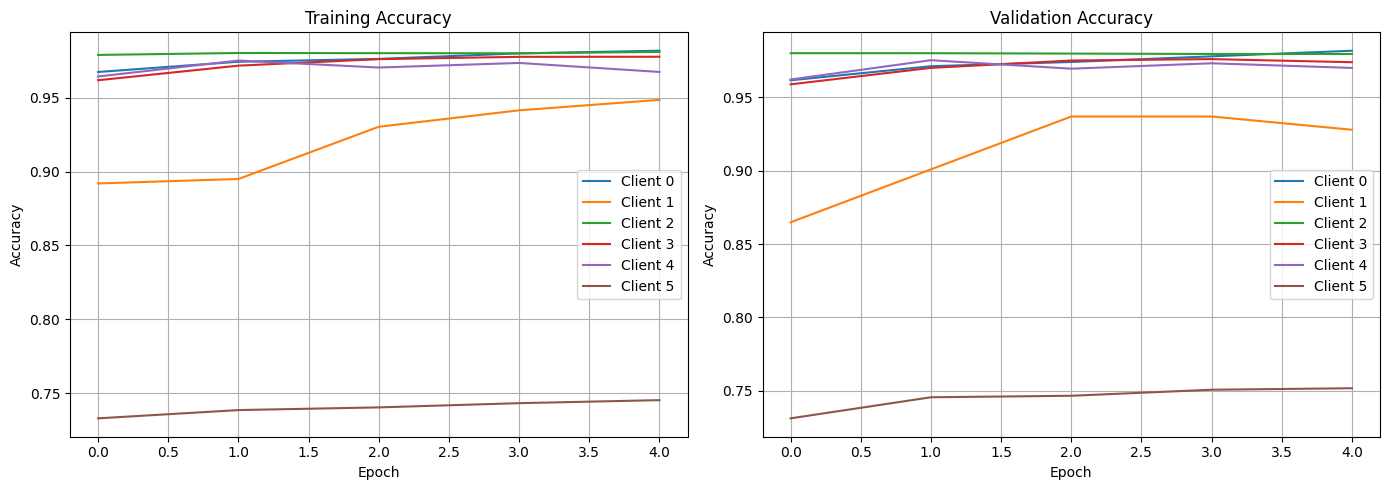

In [2]:

plt.figure(figsize=(14, 5))

# Train Accuracy
plt.subplot(1, 2, 1)
for i in range(NUM_CLIENTS):
    plt.plot(history_train[i], label=f'Client {i}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(NUM_CLIENTS):
    plt.plot(history_val[i], label=f'Client {i}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

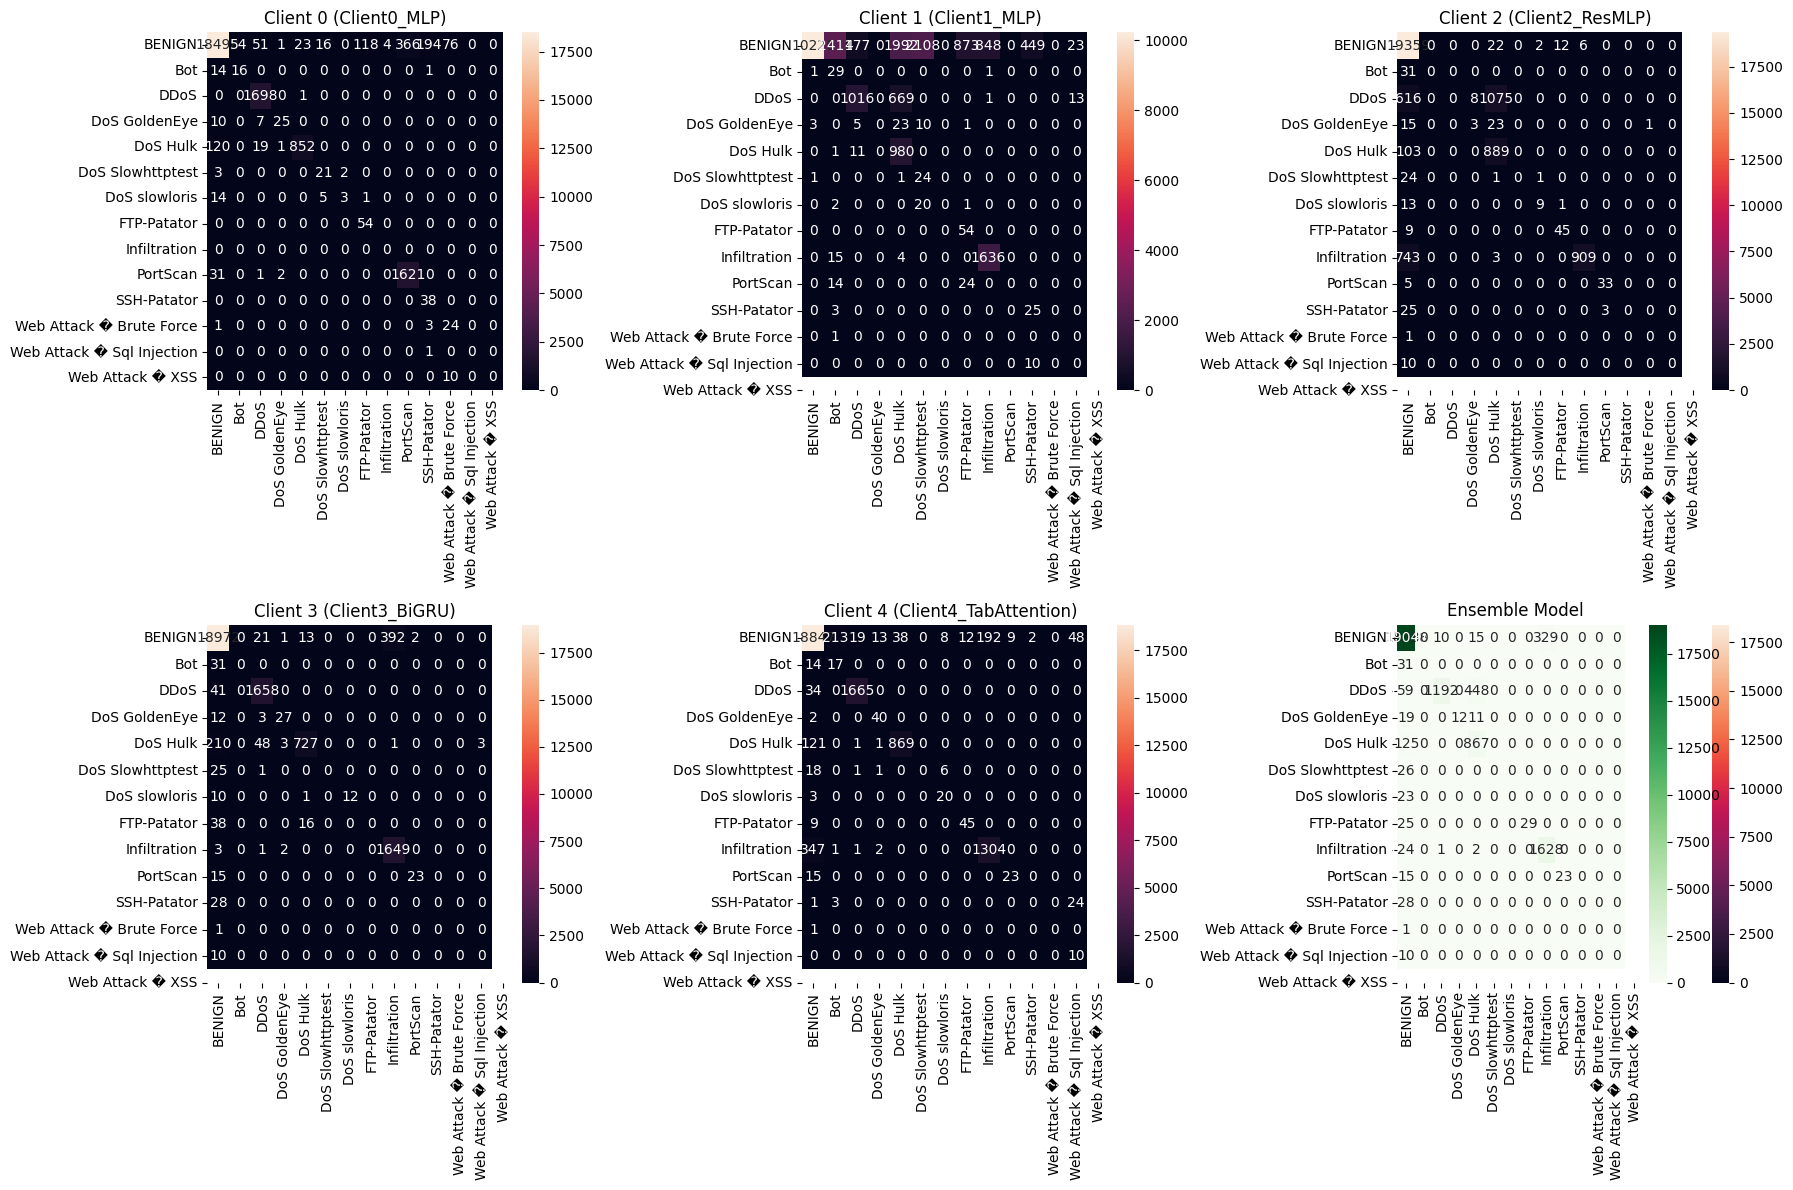

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for cid in range(NUM_CLIENTS):
    y_pred = torch.argmax(models[cid](X_test_tensor), dim=1).cpu().numpy()
    sns.heatmap(
        confusion_matrix(y_test_global, y_pred),
        annot=True,
        fmt='d',
        ax=axes[cid],
        xticklabels=le.classes_,
        yticklabels=le.classes_
    )
    axes[cid].set_title(f'Client {cid} ({models[cid].__class__.__name__})')

# Ensemble confusion matrix
sns.heatmap(
    confusion_matrix(y_test_global, y_pred_ens),
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[5],
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
axes[5].set_title('Ensemble Model')

plt.tight_layout()
plt.show()